In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision.datasets
import torchvision.transforms as T
import torchvision.models

In [2]:
import sys
if 'trainer' in sys.modules:
    del sys.modules['trainer']
import trainer
from trainer import device

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [4]:
dataset = torchvision.datasets.VOCDetection(".", download=True, image_set="trainval", transforms=lambda x, y: voc_transform(x, y))
classes = {'__none__':0, 'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4, 'bottle':5, 'bus':6, 'car':7, 'cat':8, 'chair':9, 'cow':10, 'diningtable':11, 'dog':12, 'horse':13, 'motorbike':14, 'person':15, 'pottedplant':16, 'sheep':17, 'sofa':18, 'train':19, 'tvmonitor':20}

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [5]:
def voc_transform(x, y, grid=13):
    ann = y["annotation"]
    width, height = int(ann["size"]["width"]), int(ann["size"]["height"])

    x = T.functional.to_tensor(x)
    x = T.functional.resize(x, [grid*32, grid*32], antialias=False)

    y = torch.zeros((5, grid, grid))
    for obj in ann["object"]:
        bbox = obj["bndbox"]
        clsid = classes[obj["name"]]
        bx, by, bw, bh = int(bbox["xmin"]) / width, int(bbox["ymin"]) / height, (int(bbox["xmax"]) - int(bbox["xmin"])) / width, (int(bbox["ymax"]) - int(bbox["ymin"])) / height
        cx, cy = int((bx + bw * 0.5) * grid), int((by + bh * 0.5) * grid)
        y[:, cx, cy] = torch.tensor([clsid, bx, by, bw, bh])

    return x, y

In [59]:
def voc_display(x, y):
    fig, ax = plt.subplots()
    ax.imshow(x.permute(1, 2, 0))
    w, h = x.shape[2], x.shape[1]
    palette = "rgbcmy"
    index = 0
    for cx in range(y.shape[1]):
        for cy in range(y.shape[2]):
            obj = y[:, cx, cy]
            if obj[0] == 0:
                continue
            name = next(n for n,i in classes.items() if i == int(obj[0]))
            bx, by, bw, bh = obj[1:]
            color = palette[index % len(palette)]
            index += 1
            rect = patches.Rectangle((bx * w, (by+bh) * h), bw * w, -bh * h, linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(bx * w + 4, by * h - 4, name, c=color)
    plt.show()

In [8]:
batch_size = 32
train_cutoff = int(len(dataset) * 0.9)
train_data = D.DataLoader(D.Subset(dataset, range(train_cutoff)), batch_size=batch_size, num_workers=4)
val_data = D.DataLoader(D.Subset(dataset, range(train_cutoff, len(dataset))), batch_size=batch_size, num_workers=4)

In [9]:
# as a backbone, we're going to use VGG feature detector. Larger models could improve the quality. We're standardizing on 416x416 => 13x13 networks though so it has to be 5-deep
vgg = torchvision.models.vgg11(weights="DEFAULT").features
for p in vgg.parameters():
    p.requires_grad=False

In [186]:
class SSD(nn.Module):
    def __init__(self, backbone, boxes=1, classes=21, grid=13, channels=512):
        super().__init__()
        self.grid = grid
        self.anchor = (3/grid,3/grid) # just a single 3-cell anchor for now
        
        self.backbone = backbone    
        self.detect = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, boxes*(4+classes), kernel_size=1))
        
        self.register_buffer('gridoffx', torch.arange(grid)/grid)
        self.register_buffer('gridoffy', torch.unsqueeze(torch.arange(grid), dim=1)/grid)

    def forward(self, x):
        # normalize image using VGG mean/std
        x = (x - 0.456) / 0.224

        # detect box candidates
        y = self.backbone(x)
        y = self.detect(y)
        
        # transform box xywh to image space
        y[:, 0, :, :] = F.sigmoid(y[:, 0, :, :])/self.grid + self.gridoffx
        y[:, 1, :, :] = F.sigmoid(y[:, 1, :, :])/self.grid + self.gridoffy
        y[:, 2, :, :] = torch.exp(y[:, 2, :, :])*self.anchor[0]
        y[:, 3, :, :] = torch.exp(y[:, 3, :, :])*self.anchor[1]
        
        # we infer center of bbox, so we need to convert it to corner
        y[:, 0, :, :] -= y[:, 2, :, :] * 0.5;
        y[:, 1, :, :] -= y[:, 3, :, :] * 0.5;

        return y
    
    @torch.no_grad()
    def predict(self, x):
        p = self.forward(x)

        plog = p[:, 4:, :, :]
        pbox = p[:, :4, :, :]

        pcat = plog.argmax(dim=1, keepdim=True)
        return torch.cat((pcat, pbox), dim=1)
    
    def loss(self, p, y):
        ycat = y[:, 0, :, :]
        ybox = y[:, 1:, :, :]
        
        plog = p[:, 4:, :, :]
        pbox = p[:, :4, :, :]

        # we need to only consider box losses for present gt objects
        ymask = (ycat > 0).float()
        ynum = ymask.sum((1,2))
        
        # SSD paper uses a more complicated formulation since it uses multiple default boxes but uhhh this is complex enough for now
        lcat = F.cross_entropy(plog, ycat.long(), reduction='none')
      
        wheps = 1e-3 # slightly bias w/h because our ground truth contains zeroes
        lboxx = F.smooth_l1_loss(pbox[:, 0], ybox[:, 0], reduction='none')
        lboxy = F.smooth_l1_loss(pbox[:, 1], ybox[:, 1], reduction='none')
        lboxw = F.smooth_l1_loss(torch.log(pbox[:, 2] + wheps), torch.log(ybox[:, 2] + wheps), reduction='none')
        lboxh = F.smooth_l1_loss(torch.log(pbox[:, 3] + wheps), torch.log(ybox[:, 3] + wheps), reduction='none')
        lbox = (lboxx + lboxy + lboxw + lboxh) * ymask
        
        # total loss per batch per dimension needs to be normalized by the number of gt objects (per batch) and averaged across batches
        return ((lcat.sum((1,2)) + lbox.sum((1,2))) / ynum.clamp(min=1)).mean()

Train [11.856M params]: 50 epochs took 2136.38 sec, train loss 0.174728, val loss 26.076364


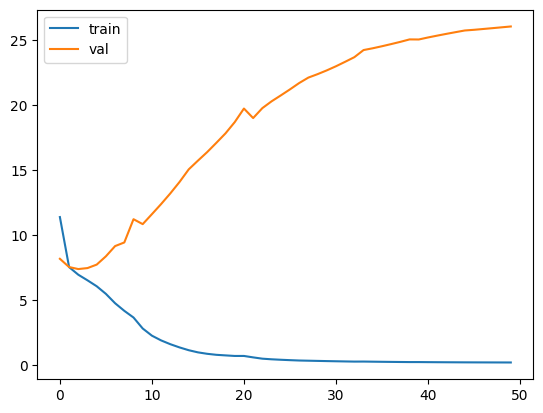

In [189]:
net = SSD(vgg).to(device)
trainer.train(net, train_data, val_data, epochs=50)

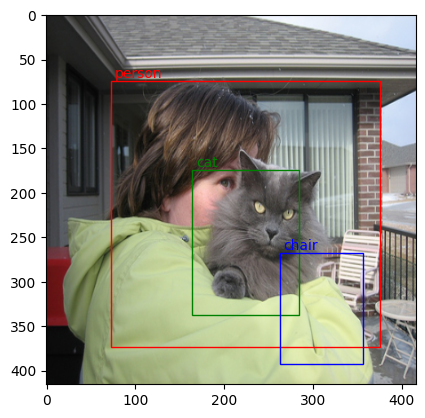

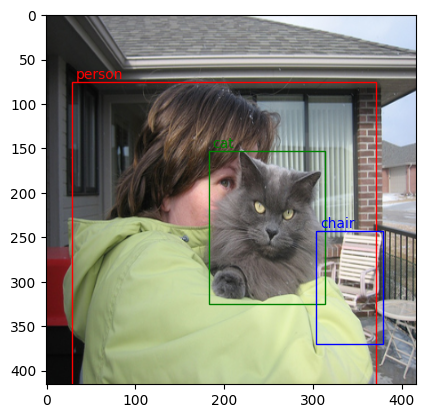

tensor(38.7090, device='cuda:0', grad_fn=<MeanBackward0>)

In [240]:
idx = 419
xex = dataset[idx][0]
pex = net(torch.unsqueeze(x.to(device), dim=0))
yex = torch.squeeze(net.predict(torch.unsqueeze(xex.to(device), dim=0)), dim=0).cpu().detach()
lex = net.loss(pex, torch.unsqueeze(dataset[idx][1].to(device), dim=0))
voc_display(xex, yex)
voc_display(xex, dataset[idx][1])
lex